In [32]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow tqdm --quiet

In [33]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
import io, warnings
warnings.filterwarnings("ignore")

In [34]:
# Step 2: Upload All 3 CSVs
# ---------------------------------------------
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))

# Auto-detect filenames
history_file = [f for f in uploaded if 'history' in f.lower()][0]
action_file  = [f for f in uploaded if 'action' in f.lower()][0]
info_file    = [f for f in uploaded if 'info'    in f.lower()][0]

# Load datasets
history = pd.read_csv(io.BytesIO(uploaded[history_file]))
actions = pd.read_csv(io.BytesIO(uploaded[action_file]))
info    = pd.read_csv(io.BytesIO(uploaded[info_file]))

print(f"✅ Loaded Files: History={history.shape}, Actions={actions.shape}, Info={info.shape}")

Saving TCS_stock_info.csv to TCS_stock_info (1).csv
Saving TCS_stock_history.csv to TCS_stock_history (1).csv
Saving TCS_stock_action.csv to TCS_stock_action (1).csv
Uploaded files: ['TCS_stock_info (1).csv', 'TCS_stock_history (1).csv', 'TCS_stock_action (1).csv']
✅ Loaded Files: History=(4463, 8), Actions=(70, 3), Info=(150, 2)


In [36]:
# Step 3: Clean and Merge Data
# ---------------------------------------------
history['Date'] = pd.to_datetime(history['Date'], errors='coerce')
actions['Date'] = pd.to_datetime(actions['Date'], errors='coerce')

# --- Normalize column names to lowercase ---
actions.columns = actions.columns.str.strip().str.lower()
history.columns = history.columns.str.strip().str.lower()

# Check what columns exist in actions
print("🧾 Columns in 'actions' file:", actions.columns.tolist())

# --- Merge data safely ---
df = pd.merge(history, actions, on='date', how='left')

# --- Fill missing dividend/split columns if not present ---
for col in ['dividends', 'stock splits', 'stock_splits']:
    if col in df.columns:
        df[col] = df[col].fillna(0)
    else:
        # If missing, create a zero column
        df[col] = 0

# Unify possible variants
if 'stock_splits' in df.columns:
    df['stock splits'] = df['stock_splits']

# Sort and preview
df = df.sort_values(by='date')
print("✅ Combined Data:", df.shape)
print(df.head())


🧾 Columns in 'actions' file: ['date', 'dividends', 'stock splits']
✅ Combined Data: (4463, 13)
        date       open       high        low      close  volume  dividends_x  \
0 2002-08-12  28.794172  29.742206  28.794172  29.519140  212976          0.0   
1 2002-08-13  29.556316  30.030333  28.905705  29.119476  153576          0.0   
2 2002-08-14  29.184536  29.184536  26.563503  27.111877  822776          0.0   
3 2002-08-15  27.111877  27.111877  27.111877  27.111877       0          0.0   
4 2002-08-16  26.972458  28.255089  26.582090  27.046812  811856          0.0   

   stock splits_x  dividends_y  stock splits_y  dividends  stock splits  \
0             0.0          NaN             NaN          0             0   
1             0.0          NaN             NaN          0             0   
2             0.0          NaN             NaN          0             0   
3             0.0          NaN             NaN          0             0   
4             0.0          NaN             

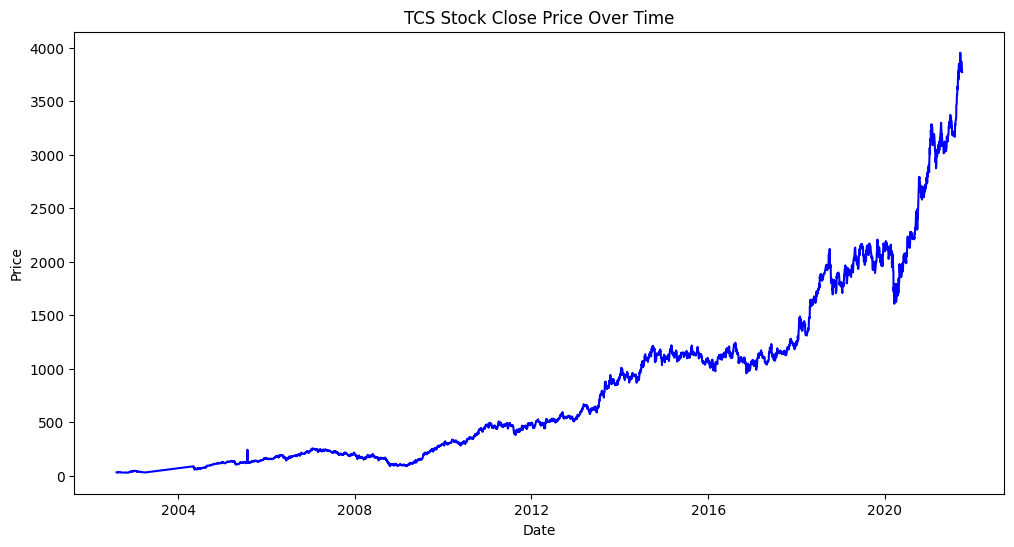

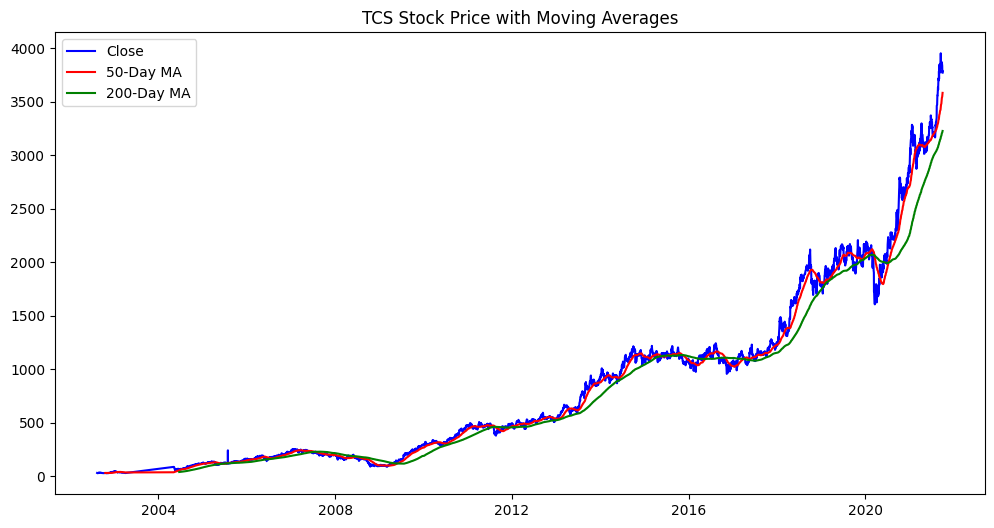

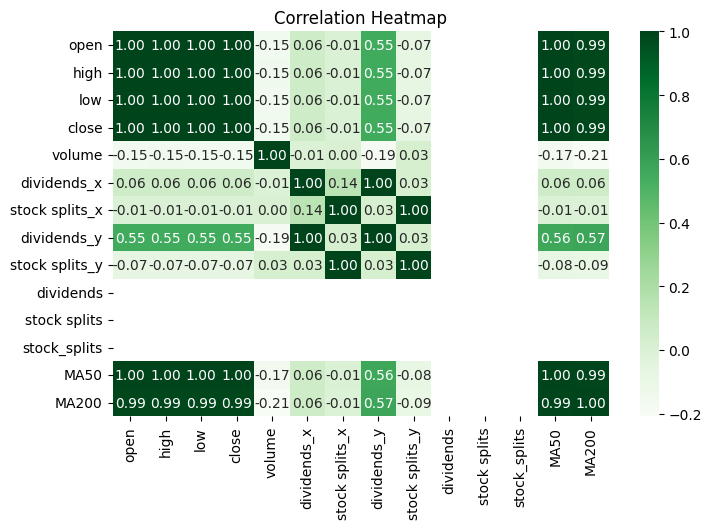

In [37]:
# Step 4: EDA
# ---------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], color='blue')
plt.title('TCS Stock Close Price Over Time')
plt.xlabel('Date'); plt.ylabel('Price')
plt.show()

# Moving averages
df['MA50'] = df['close'].rolling(window=50).mean()
df['MA200'] = df['close'].rolling(window=200).mean()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], label='Close', color='blue')
plt.plot(df['date'], df['MA50'], label='50-Day MA', color='red')
plt.plot(df['date'], df['MA200'], label='200-Day MA', color='green')
plt.title('TCS Stock Price with Moving Averages')
plt.legend(); plt.show()

# Correlation heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Greens', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [39]:
 #Step 5: Feature Engineering
# ---------------------------------------------
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['prev_close'] = df['close'].shift(1)
df.dropna(inplace=True)


📈 Linear Regression Results:
Mean Squared Error : 601.65
R² Score           : 0.999


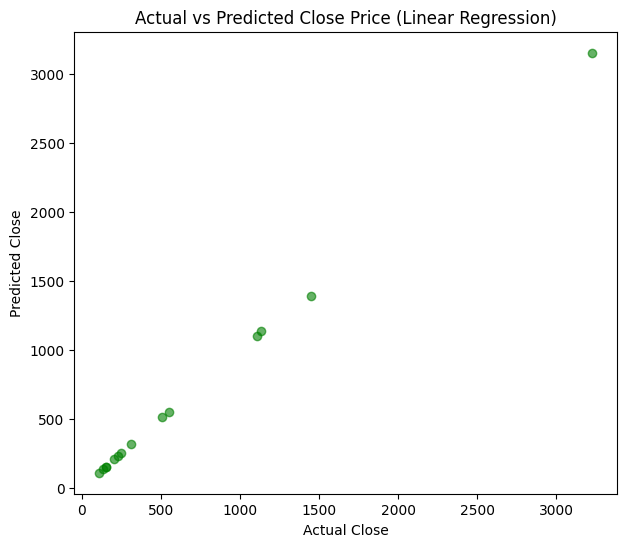

In [40]:
# Step 6: Linear Regression Model
# ---------------------------------------------
X = df[['open', 'high', 'low', 'volume', 'prev_close', 'day_of_week', 'month']]
y = df['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("\n📈 Linear Regression Results:")
print(f"Mean Squared Error : {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score           : {r2_score(y_test, y_pred):.3f}")

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.xlabel('Actual Close'); plt.ylabel('Predicted Close')
plt.title('Actual vs Predicted Close Price (Linear Regression)')
plt.show()



🧠 Training LSTM Model...


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


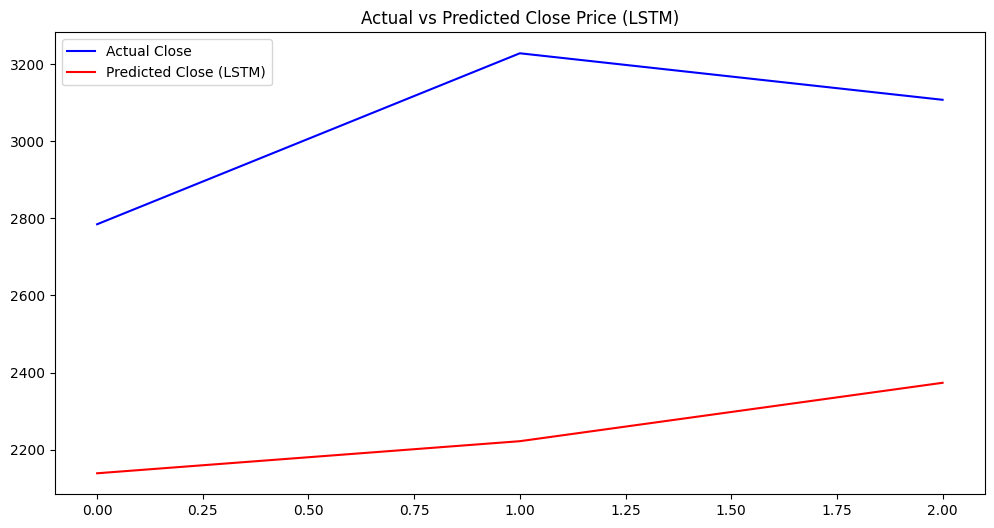

LSTM Mean Absolute Error: 795.01


In [41]:
# Step 7: LSTM Deep Learning Model
# ---------------------------------------------
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['close']])

train_size = int(len(scaled_close) * 0.8)
train_data, test_data = scaled_close[:train_size], scaled_close[train_size:]

def create_lstm_data(data, step=10):
    X, y = [], []
    for i in range(len(data) - step - 1):
        X.append(data[i:i+step, 0])
        y.append(data[i+step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_train_lstm, y_train_lstm = create_lstm_data(train_data, time_step)
X_test_lstm,  y_test_lstm  = create_lstm_data(test_data, time_step)

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm  = X_test_lstm.reshape(X_test_lstm.shape[0],  X_test_lstm.shape[1],  1)

model_lstm = Sequential([
    LSTM(50, input_shape=(time_step,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print("\n🧠 Training LSTM Model...")
for epoch in tqdm(range(20)):
    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=1, batch_size=15, verbose=0)

# Predictions
predictions = model_lstm.predict(X_test_lstm)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Close', color='blue')
plt.plot(predictions, label='Predicted Close (LSTM)', color='red')
plt.title('Actual vs Predicted Close Price (LSTM)')
plt.legend(); plt.show()

mae = mean_absolute_error(actual, predictions)
print(f"LSTM Mean Absolute Error: {mae:.2f}")

In [42]:
# Step 8: Save Models
# ---------------------------------------------
import pickle
with open('TCS_Stock_LR_Model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
model_lstm.save('TCS_Stock_LSTM_Model.h5')

print("\n✅ Models saved successfully!")


✅ Models saved successfully!
